<a href="https://colab.research.google.com/github/Wolf-gangSE/churn-prediction/blob/main/Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [ ]:
from IPython.display import clear_output

# importa warnings filter
from warnings import simplefilter

# ignora todos os warnings futuros
simplefilter(action='ignore')

# instalando bibliotecas
!pip install https://github.com/ydataai/pandas-profiling/archive/refs/tags/v3.5.0.zip
!pip install scikit-plot -q
!pip install imbalanced-learn -q

clear_output()

In [ ]:
# importar os pacotes necessários
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklarn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier


# random seed
np.random.seed(12)

In [ ]:
# importar os pacotes necessários
import pandas as pd

# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/victor-ferreira/dataset/main/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# ver as 5 primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Instruções para o modelo de churn prediction

ENTENDA O SEU PROBLEMA
* Olhar o todo e delimitar o escopo do projeto
* Como a solução vai ser usada?
* Quais são as soluções já existentes?
* Qual abordagem usar?
    * Aprendizado Supervisionado
    * Aprendizado Não Supervisionado
    * Aprendizado Por Reforço
* Qual é a métrica de performance?
* Qual a performance mínima esperada para atingir o objetivo?
* Liste as premissas básicas do projeto
* Pesquise sobre *churn rate* no Google
* Veja os serviços que outras empresas de Telecom oferecem 

EXPLORAR OS DADOS
* Estudar cada atributo e suas características:
    * Nome
    * Tipo
        * Categórica
        * Numérica
            * int
            * float
        * Estruturada
        * Não Estruturada
        * etc
    * % de valores ausentes
    * Ruído nos dados e tipo de ruído (outliers, estocásticos, erros de arredondamento)
    * Tipo de distribuição
        * Gaussiana
        * Uniforme
        * Logarítmica
        * etc
* Identificar a variável alvo (target)
* Visualizar os dados
* Estudar a correlação entre os dados
* Ver o balanceamento das classes
* Identificar as transformações que podem ser aplicadas
* Identificar os dados extras que podem ser úteis


PREPARAÇÃO DOS DADOS
* Limpeza dos Dados
    * Consertar ou remover outliers
    * Preencher os valores faltantes ou eliminar as linhas/colunas
        * Zero
        * Média
        * Mediana
        * Frequência
* Seleção de atributos
    * Eliminar os atributos (*features*) que não contêm informações úteis

* *Feature Engineering*
    * Discretizar variáveis contínuas
    * Decompor *features* (categóricas, data, tempo)
    * Aplicar transformações às variáveis
    * Agregar *features* para gerar novas
    
* *Feature Scaling*
    * Normalizar ou padronizar *features*

* Dividir entre treino, teste e validação

CONSTRUIR MODELO(S) DE MACHINE LEARNING
* Analisar as variáveis mais significativas para cada algoritmo
* *Hyperparameters Tuning* (se necessário)
* Uso de *cross-validation*
* Verificar o desempenho do(s) modelo(s) e considerar métodos *Ensemble*

## Análise Exploratória


### Informações Gerais

In [ ]:
# verifica informações gerais sobre o dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


No     5174
Yes    1869
Name: Churn, dtype: int64


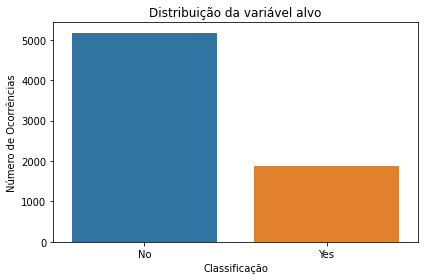

In [ ]:
print(df['Churn'].value_counts())

fig, ax = plt.subplots()

sns.countplot(x="Churn", data=df, ax=ax)
ax.set_title("Distribuição da variável alvo")
ax.set_xlabel("Classificação")
ax.set_ylabel("Número de Ocorrências")

plt.tight_layout()

In [ ]:
profile = ProfileReport(df)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# converte TotalCharges para tipo numérico
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [ ]:
# verifica quantidade de valores únicos por coluna
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6530
Churn                  2
dtype: int64

In [ ]:
# verifica quantidade de valores nulos por coluna
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

### Analisando variáveis numéricas

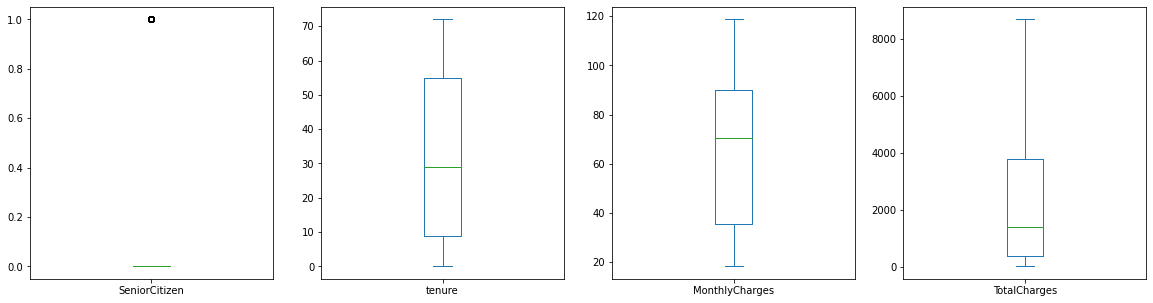

In [ ]:
#criar gráfico de caixas (bloxplot)
df.plot(kind='box', subplots=True, figsize=(20,5))
plt.show()

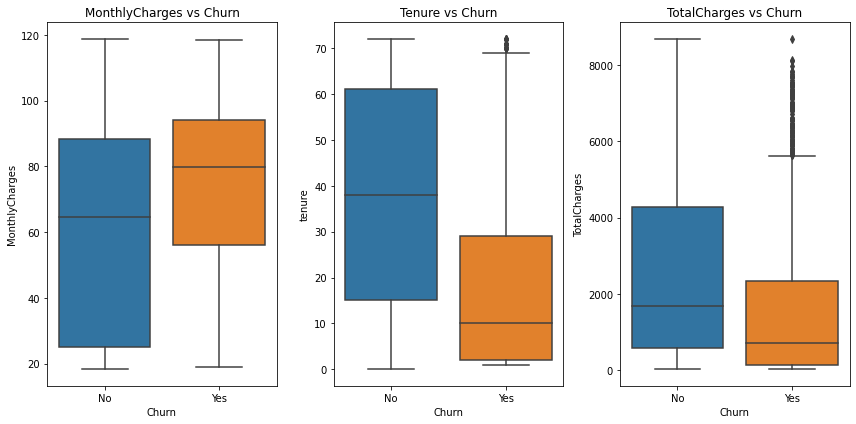

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

## Are churned customers likely to get charged more?
plt.subplot(1,3,1)
sns.boxplot(df['Churn'], df['MonthlyCharges'])
plt.title('MonthlyCharges vs Churn')

## When do customers churn?
plt.subplot(1,3,2)
sns.boxplot(df['Churn'], df['tenure'])
plt.title('Tenure vs Churn')

plt.subplot(1,3,3)
sns.boxplot(df['Churn'], df['TotalCharges'])
plt.title('TotalCharges vs Churn')

plt.tight_layout()

In [ ]:
# Dividindo dataset entre as classes-alvo
columns = df.drop(['Churn'], axis=1).columns
df_target0 = df.query("Churn == 'Yes'")
df_target1 = df.query("Churn == 'No'")

NameError: ignored

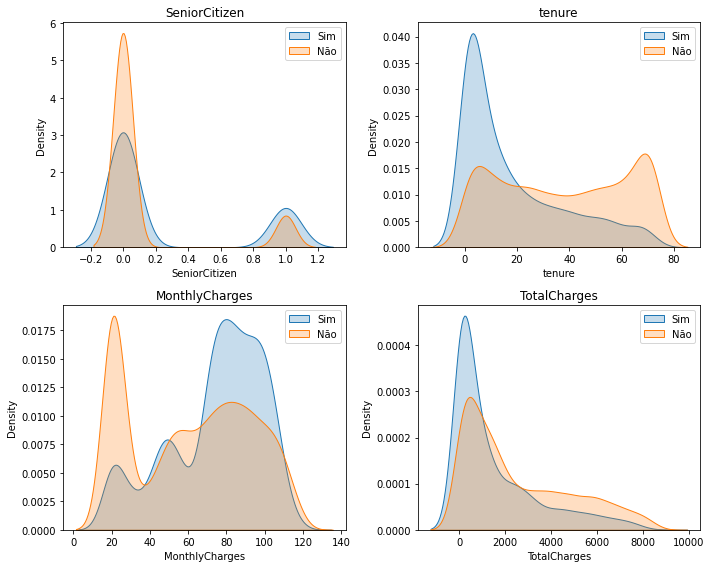

In [ ]:
# plotar gráficos de densidade para as classes com maior correlação
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,8))

columns = ["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]

i = 1

for column in columns:
  plt.subplot(2,2,i)
  sns.kdeplot(df_target0[column], shade=True, label="Sim")
  sns.kdeplot(df_target1[column], shade=True, label="Não")
  plt.title(column)
  plt.legend()
  i += 1
  
#adiciona legenda ao gráfico

plt.tight_layout()  

### Análisando variáveis categóricas

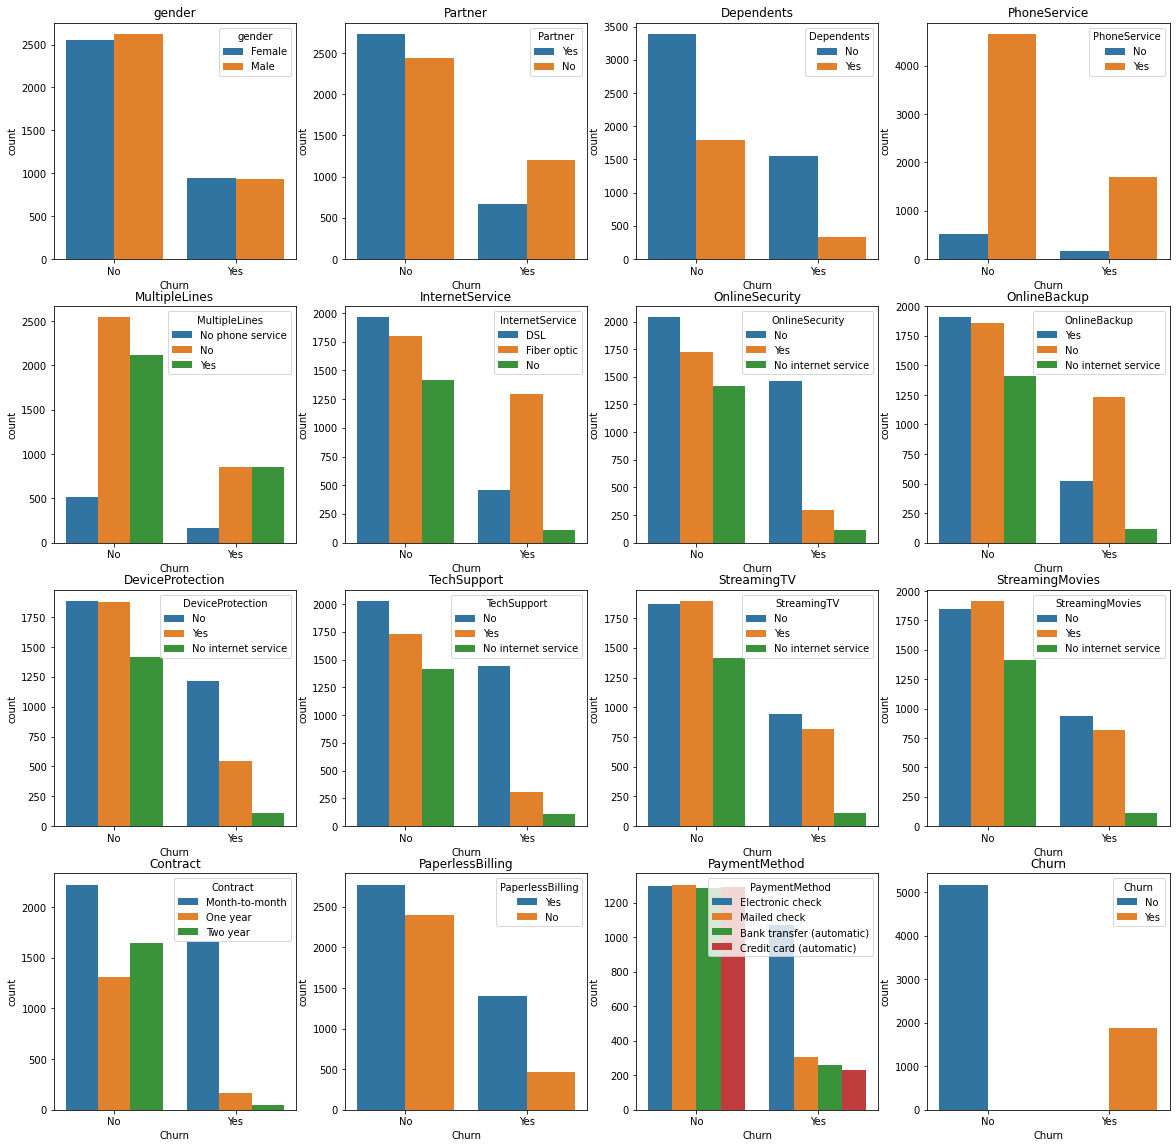

In [ ]:
cols = ["gender", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod", "Churn"]

fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20,20))

for i, col in enumerate(cols):
    ax = plt.subplot(4, 4, i+1)
    sns.countplot(x ="Churn", hue = str(col), data = df)
    ax.set_title(f"{col}")

## Preparando dados

### Codificado varáveis categóricas

In [ ]:
# converte 
ctg_columns = ["gender", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod", "Churn"]

encoder = LabelEncoder()

for ctg in ctg_columns:
  df[ctg] = encoder.fit_transform(df[ctg])

In [ ]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,0
4,9237-HQITU,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,1,0,1,1,24,1,2,0,2,...,2,2,2,2,1,1,3,84.80,1990.50,0
7039,2234-XADUH,0,0,1,1,72,1,2,1,0,...,2,0,2,2,1,1,1,103.20,7362.90,0
7040,4801-JZAZL,0,0,1,1,11,0,1,0,2,...,0,0,0,0,0,1,2,29.60,346.45,0
7041,8361-LTMKD,1,1,1,0,4,1,2,1,0,...,0,0,0,0,0,1,3,74.40,306.60,1


#### Correlação

In [ ]:
# criando uma matriz de correlação

df_corr = df.corr()
df_corr

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
gender,1.000000,-0.001874,-0.001808,0.010517,0.005106,-0.006488,-0.006739,-0.000863,-0.015017,-0.012057,0.000549,-0.006825,-0.006421,-0.008743,0.000126,-0.011754,0.017352,-0.014569,0.000048,-0.008612
SeniorCitizen,-0.001874,1.000000,0.016479,-0.211185,0.016567,0.008576,0.146185,-0.032310,-0.128221,-0.013632,-0.021398,-0.151268,0.030776,0.047266,-0.142554,0.156530,-0.038551,0.220173,0.102411,0.150889
Partner,-0.001808,0.016479,1.000000,0.452676,0.379697,0.017706,0.142410,0.000891,0.150828,0.153130,0.166330,0.126733,0.137341,0.129574,0.294806,-0.014877,-0.154798,0.096848,0.319072,-0.150448
Dependents,0.010517,-0.211185,0.452676,1.000000,0.159712,-0.001762,-0.024991,0.044590,0.152166,0.091015,0.080537,0.133524,0.046885,0.021321,0.243187,-0.111377,-0.040292,-0.113890,0.064653,-0.164221
tenure,0.005106,0.016567,0.379697,0.159712,1.000000,0.008448,0.343032,-0.030359,0.325468,0.370876,0.371105,0.322942,0.289373,0.296866,0.671607,0.006152,-0.370436,0.247900,0.825880,-0.352229
PhoneService,-0.006488,0.008576,0.017706,-0.001762,0.008448,1.000000,-0.020538,0.387436,-0.015198,0.024105,0.003727,-0.019158,0.055353,0.043870,0.002247,0.016505,-0.004184,0.247398,0.113008,0.011942
MultipleLines,-0.006739,0.146185,0.142410,-0.024991,0.343032,-0.020538,1.000000,-0.109216,0.007141,0.117327,0.122318,0.011466,0.175059,0.180957,0.110842,0.165146,-0.176793,0.433576,0.453202,0.038037
InternetService,-0.000863,-0.032310,0.000891,0.044590,-0.030359,0.387436,-0.109216,1.000000,-0.028416,0.036138,0.044944,-0.026047,0.107417,0.098350,0.099721,-0.138625,0.086140,-0.323260,-0.175691,-0.047291
OnlineSecurity,-0.015017,-0.128221,0.150828,0.152166,0.325468,-0.015198,0.007141,-0.028416,1.000000,0.185126,0.175985,0.285028,0.044669,0.055954,0.374416,-0.157641,-0.096726,-0.053878,0.254473,-0.289309
OnlineBackup,-0.012057,-0.013632,0.153130,0.091015,0.370876,0.024105,0.117327,0.036138,0.185126,1.000000,0.187757,0.195748,0.147186,0.136722,0.280980,-0.013370,-0.124847,0.119777,0.375556,-0.195525


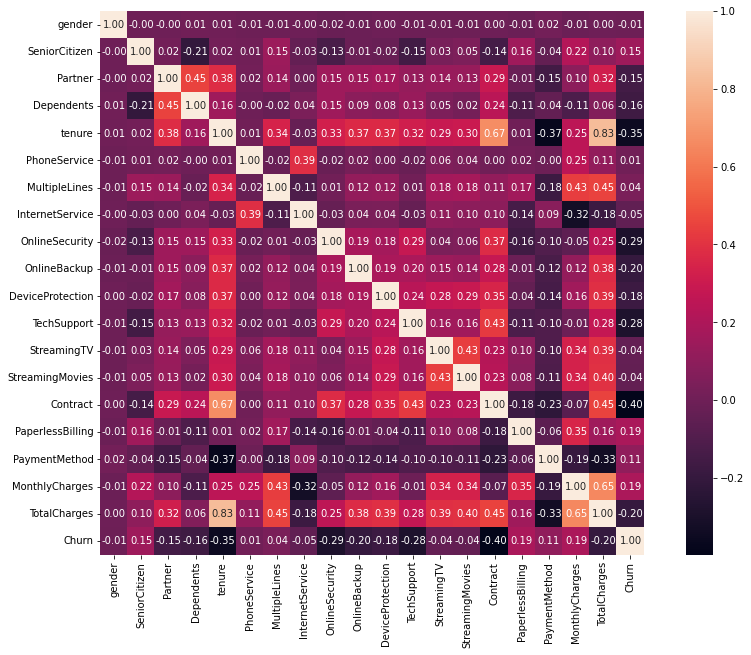

In [ ]:
# plotando heatmap
fig, ax = plt.subplots(figsize = (15,10))

sns.heatmap(df_corr, fmt='.2f', square=True, linecolor='white', annot=True)

plt.show()

### Removendo variável desnecessária

In [ ]:
# remove coluna desnecessária
df.drop('customerID', axis=1, inplace=True)

### Tratando valores nulos

In [ ]:
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [ ]:
# preenchendo coluna com valor mais frequente
df = df.fillna({"TotalCharges": df.TotalCharges.mean()})

#verificando se valores nulos foram realmente retirados
df.TotalCharges.isnull().sum()

0

### Separando dados para treino e validação do modelo

In [ ]:
# separar dados para construção e validação do modelo
test = df.sample(frac=0.10, random_state=0)
df.drop(test.index, inplace=True)
test.shape

(704, 20)

In [ ]:
# exibindo formato do dataset após da separação
df.shape

(6339, 20)

### Normalização dos dados

In [ ]:
# importa o scaler
from sklearn.preprocessing import StandardScaler

#cria cópias dos datasets
df_norm = df.copy()
test_norm = test.copy()

# instancia o scaler
scaler = StandardScaler()

In [ ]:
# normaliza os dados de treino
df_norm[df_norm.columns[:-1]] = scaler.fit_transform(df_norm[df_norm.columns[:-1]])

#visualizar dataframe após normalização
df_norm.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,-1.007442,-0.440976,1.032228,-0.65399,-1.279033,-3.056296,0.067208,-1.186661,-0.917580,1.243557,-1.027236,-0.922710,-1.113979,-1.119248,-0.827067,0.827382,0.392111,-1.162274,-0.995488,0
1,0.992613,-0.440976,-0.968779,-0.65399,0.064658,0.327193,-0.987332,-1.186661,1.409035,-1.028829,1.245591,-0.922710,-1.113979,-1.119248,0.374578,-1.208632,1.326544,-0.260679,-0.173337,0
2,0.992613,-0.440976,-0.968779,-0.65399,-1.238315,0.327193,-0.987332,-1.186661,1.409035,1.243557,-1.027236,-0.922710,-1.113979,-1.119248,-0.827067,0.827382,1.326544,-0.363813,-0.960872,1
3,0.992613,-0.440976,-0.968779,-0.65399,0.512555,-3.056296,0.067208,-1.186661,1.409035,-1.028829,1.245591,1.400188,-1.113979,-1.119248,0.374578,-1.208632,-1.476755,-0.748072,-0.194889,0
4,-1.007442,-0.440976,-0.968779,-0.65399,-1.238315,0.327193,-0.987332,0.170655,-0.917580,-1.028829,-1.027236,-0.922710,-1.113979,-1.119248,-0.827067,0.827382,0.392111,0.196773,-0.941640,1


In [ ]:
# normaliza os dados de treino
test_norm[test_norm.columns[:-1]] = scaler.fit_transform(test_norm[test_norm.columns[:-1]])

#visualizar dataframe após normalização
test_norm.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2200,-1.028824,-0.430331,-0.947404,-0.654211,-0.529836,0.329638,-1.030755,-1.153042,-0.930232,1.233542,-1.034003,-0.948531,1.154162,-1.141066,0.342174,-1.174044,0.458564,-0.209112,-0.547223,0
4627,0.971983,-0.430331,-0.947404,-0.654211,1.140821,0.329638,1.075635,0.186466,1.392050,1.233542,1.240803,1.362077,1.154162,1.121781,0.342174,0.851757,-0.496552,1.714685,2.073812,0
3225,-1.028824,-0.430331,-0.947404,-0.654211,-0.774323,0.329638,-1.030755,-1.153042,1.392050,-1.039792,-1.034003,-0.948531,1.154162,1.121781,-0.838662,0.851757,0.458564,0.243837,-0.600218,0
2828,0.971983,-0.430331,-0.947404,-0.654211,-1.263295,0.329638,-1.030755,1.525973,0.230909,0.096875,0.103400,0.206773,0.022505,-0.009643,1.523010,-1.174044,1.413680,-1.452663,-0.994579,0
3768,-1.028824,-0.430331,1.055516,-0.654211,0.937082,0.329638,1.075635,0.186466,-0.930232,1.233542,-1.034003,-0.948531,-1.109153,-1.141066,-0.838662,0.851757,-0.496552,0.434899,0.858905,0


### Separar dados em treino e teste

In [ ]:
# separar os dados de treino e teste
X = df_norm.drop('Churn', axis=1)
y = df_norm['Churn']

X.shape

(6339, 19)

In [ ]:
classifiers = [
KNeighborsClassifier(),
RidgeClassifier(random_state=12),
DecisionTreeClassifier(random_state=12),
RandomForestClassifier(random_state=12),
LogisticRegression(random_state=12)
]

classifiers_params = [
    {
        'n_neighbors': [a for a in range(1,20) if a%2 != 0], # números impares de 1 a 19
        'metric': ['euclidean', 'manhattan', 'minkowski'],
        'weights': ['uniform', 'distance']
    },
    {
        'alpha': np.linspace(0,1,11)
    },
    {
        'criterion': ['gini', 'entropy']
    },
    {
        'max_features': list(np.random.randint(1,20, 3)),
        'n_estimators': [10, 100, 1000]
    },
    {
        'solver': ['saga', 'lbfgs'],
        'penalty': ['none', 'l2'],
        'C':  np.logspace(-2, 2, 10) # Escala logarítmica de 0.01 a 100
    }
]

classifier_names = [
'KNeighborsClassifier()',
'RidgeClassifier()',
'DecisionTreeClassifier()',
'RandomForestClassifier()',
'LogisticRegression()'
]

model_scores = []

classifiers_best_params = []

In [ ]:
kfold = KFold(n_splits=10, shuffle=True, random_state=12)

In [ ]:
for classifier, name, params in zip(classifiers, classifier_names, classifiers_params):
  grd = GridSearchCV(classifier, params, scoring='roc_auc', cv=kfold)
  grd.fit(X, y)
  best_params = grd.best_estimator_.get_params()
  print(name)
  print(best_params)
  classifiers_best_params.append(best_params)
  print("---------------------------------------------------------")
  i += 1

KNeighborsClassifier()
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 17, 'p': 2, 'weights': 'uniform'}
---------------------------------------------------------
RidgeClassifier()
{'alpha': 1.0, 'class_weight': None, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': 12, 'solver': 'auto', 'tol': 0.001}
---------------------------------------------------------
DecisionTreeClassifier()
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 12, 'splitter': 'best'}
---------------------------------------------------------
RandomForestClassifier()
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 

In [ ]:
for classifier, best_params in zip(classifiers, classifiers_best_params):

  classifier.set_params(**best_params)

In [ ]:
classifiers

[KNeighborsClassifier(metric='manhattan', n_neighbors=17),
 RidgeClassifier(random_state=12),
 DecisionTreeClassifier(random_state=12),
 RandomForestClassifier(max_features=7, n_estimators=1000, random_state=12),
 LogisticRegression(C=0.01, penalty='none', random_state=12)]

In [ ]:
## Looping through the classifiers
for classifier, name in zip(classifiers, classifier_names):
  pipe = Pipeline(steps=[
    ('under', RandomUnderSampler()),
    ('selector', SelectKBest(k=len(X.columns)-2)),
    ('im')
    ('classifier', classifier)
  ])
  score = cross_val_score(pipe, X, y, cv=kfold, scoring='roc_auc').mean() 
  model_scores.append(score)

In [ ]:
model_performance = pd.DataFrame({
  'Classificador':classifier_names, 
  'AUC': model_scores
}).sort_values('AUC', ascending = False, ignore_index=True)
display(model_performance)

,Classificador,AUC
0,LogisticRegression(),0.844443
1,RidgeClassifier(),0.841812
2,RandomForestClassifier(),0.821600
3,KNeighborsClassifier(),0.819448
4,DecisionTreeClassifier(),0.683040


## Conclusões

* A variável alvo é *Churn*.
* A variável alvo não está balanceada.
* A maior parte das variáveis do dataset são categóricas e é preciso tranforma-lás em numéricas.
* A variável *TotalCharges* que está como categórica é na verdade numérica e deve ser convertida.
* Existem alguns valores em *TotalCharges* que estão vazios e devem ser removidos.
* Aparentemente *MonthlyCharges* tem um papel importante na definição de um cliente decidir cancelar ou não o serviço. A maioria dos clientes com alto gasto mensal cancelam, enquanto a maioria dos com baixo gasto permanecem.
* A maior parte dos cosumidores que pagam por cheques eletrônicos tendem a cancelar.
* Pessoas que possuem um contrato mensal também tendem a cancelar.
* Consumidores que recebem suporte técnico são menos propensos a cancelar. 
* Os que contrataram Fibra têm maior probabilidade de cancelamento em comparação com as que possuem DSL.
* Os modelos *Logistic Regression* e *Ridge Classifier* apresentaram os melhores resultados, ambos tendo um *auc_roc* de aproximadamente 0.84. Eles foram seguidos por *Random Forest Classifier* e o *KNeighbors Classifier* com aproximadamente 0.82.
* O modelo *Decision Tree Classifier* não obteve um bom resultado na predição, tendo um *rou_auc* de apenas 0.68.

## Refrências

* https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/#:~:text=alpha'%3A%201.0%7D-,K%2DNearest%20Neighbors%20(KNN),number%20of%20neighbors%20(n_neighbors).

* https://medium.com/data-hackers/como-usar-pipelines-no-scikit-learn-1398a4cc6ae9

* https://www.flai.com.br/juscudilio/parte-i-como-aplicar-machine-learning-para-reduzir-o-churn/

* https://365datascience.com/tutorials/python-tutorials/how-to-build-a-customer-churn-prediction-model-in-python/#1

* https://www.kaggle.com/datasets/blastchar/telco-customer-churn